In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# sklearn.calibration.calibration_curve
from sklearn.calibration import calibration_curve

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/red-wine-quality-cortez-et-al-2009.zip"
df = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

Get to know the data, what should we do?

In [4]:
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


<IPython.core.display.Javascript object>

In [5]:
df.isna().mean()

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

<IPython.core.display.Javascript object>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


<IPython.core.display.Javascript object>

In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<IPython.core.display.Javascript object>

In [8]:
df["quality"].value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

<IPython.core.display.Javascript object>

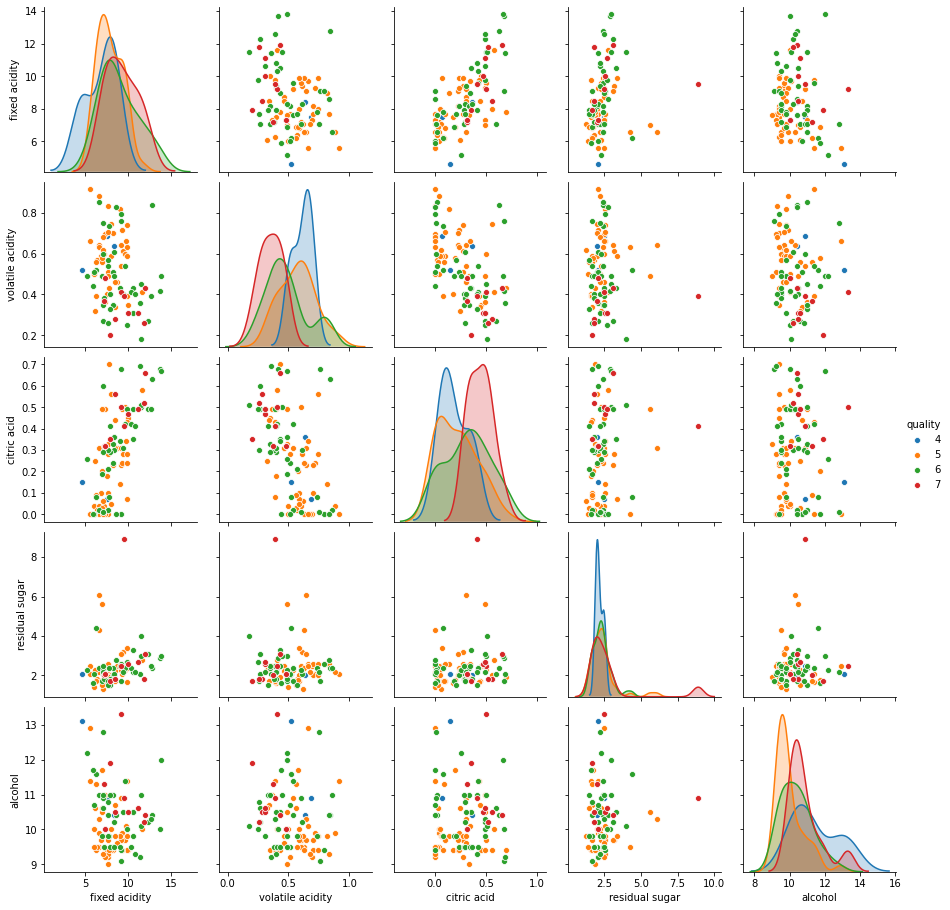

<IPython.core.display.Javascript object>

In [9]:
cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "alcohol",
    "quality",
]

sns.pairplot(df[cols].sample(100), hue="quality")
plt.show()

We want to predict `'quality'` (we're going to convert it to binary).  What's the current distribution of scores? (create a histogram).

In [10]:
df["quality"].value_counts(normalize=True).sort_index()

3    0.006254
4    0.033146
5    0.425891
6    0.398999
7    0.124453
8    0.011257
Name: quality, dtype: float64

<IPython.core.display.Javascript object>

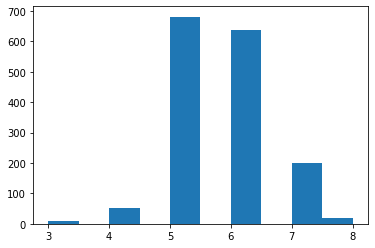

<IPython.core.display.Javascript object>

In [11]:
plt.hist(df["quality"])
plt.show()

The first decision is how to translate the continuous outcome variable to categorical. We get the best class balance (number of samples from each category) if we make a cutoff at between 5 and 6, assigning a 1 if quality is 6 or above.

This is a situation where use case comes in; in the future there will typically be a reason to choose a cutoff.

* Create a binary variable indicating quality.

In [12]:
df["quality_bin"] = df["quality"] >= 6
df["quality_bin"] = df["quality_bin"].astype(int)

<IPython.core.display.Javascript object>

* What does the distribution of this binary variable look like?

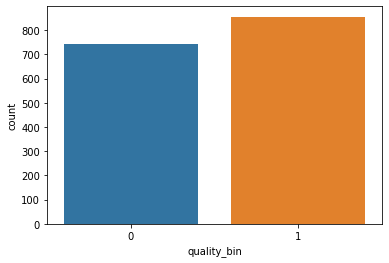

<IPython.core.display.Javascript object>

In [13]:
sns.countplot(df["quality_bin"])
plt.show()

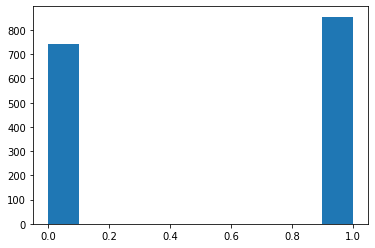

<IPython.core.display.Javascript object>

In [14]:
plt.hist(df["quality_bin"])
plt.show()

* What percentage of the binary variable are `1`s? `0`s?
* Why do we care about this?
  * If we had 80% `1`s and we ended up with 80% accuracy, is that good?

In [15]:
df["quality_bin"].value_counts(normalize=True)

1    0.534709
0    0.465291
Name: quality_bin, dtype: float64

<IPython.core.display.Javascript object>

* Split the data into `X` & `y`

In [16]:
X = df.drop(columns=["quality_bin", "quality"])
y = df["quality_bin"]

<IPython.core.display.Javascript object>

* Perform a train test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

* Create a boxplot for every feature in `X`

In [18]:
X_train.melt().head(2)

,variable,value
0,fixed acidity,8.7
1,fixed acidity,6.1


<IPython.core.display.Javascript object>

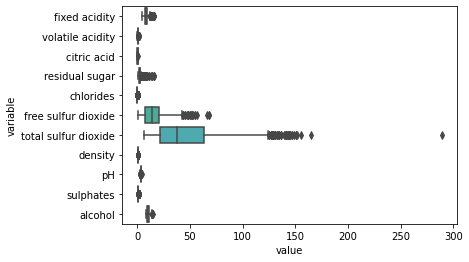

<IPython.core.display.Javascript object>

In [19]:
sns.boxplot("value", "variable", data=X_train.melt())
plt.show()

* Collinearity? Highly correlated predictors? Redundant predictors?

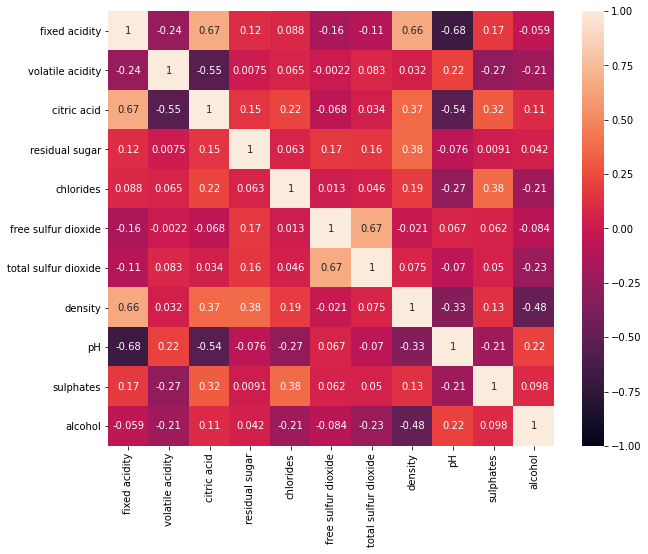

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

* What do you think will be good predictors of quality? Why? How can you prove it?

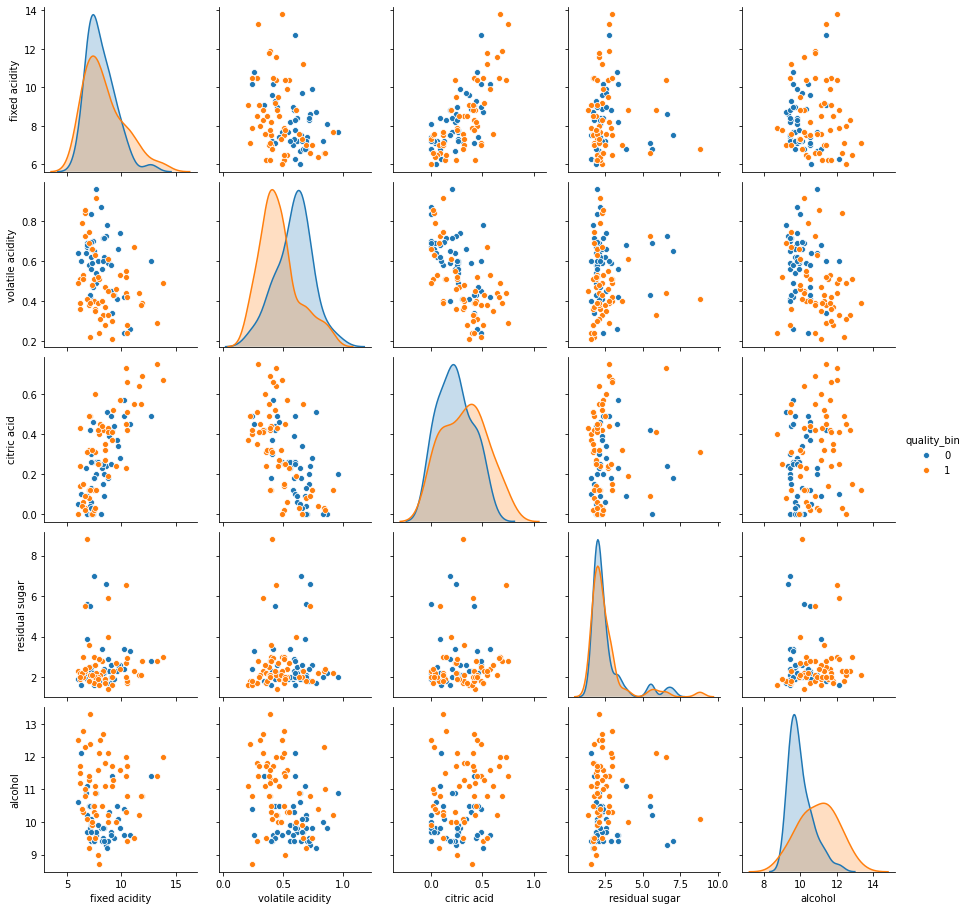

<IPython.core.display.Javascript object>

In [21]:
cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "alcohol",
    "quality_bin",
]

sns.pairplot(df[cols].sample(100), hue="quality_bin")
plt.show()

* Fit a logistic regression model to the data to predict quality.

In [22]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

* How is the model's fit?

In [23]:
model.score(X_train, y_train)

0.7490226739640344

<IPython.core.display.Javascript object>

In [24]:
model.score(X_test, y_test)

0.740625

<IPython.core.display.Javascript object>

* Build a confusion matrix

In [25]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_mat, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"]
)
conf_df

,Predicted 0,Predicted 1
Actual 0,107,34
Actual 1,49,130


<IPython.core.display.Javascript object>

* What are the coefficients of the model?

In [26]:
coef_df = pd.DataFrame({"feat": X_train.columns, "coef": model.coef_[0]})
coef_df

,feat,coef
0,fixed acidity,0.096568
1,volatile acidity,-2.516199
2,citric acid,-0.624297
3,residual sugar,-0.009471
4,chlorides,-1.028514
5,free sulfur dioxide,0.031393
6,total sulfur dioxide,-0.018245
7,density,-0.109489
8,pH,-0.194181
9,sulphates,1.943368


<IPython.core.display.Javascript object>

------

We might alternatively fit the logistic regression with `statsmodels` this has the advantage of p-values in the output that indicate if a feature is a 'significant predictor'

In [27]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.518053
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            quality_bin   No. Observations:                 1279
Model:                          Logit   Df Residuals:                     1267
Method:                           MLE   Df Model:                           11
Date:                Thu, 27 Aug 2020   Pseudo R-squ.:                  0.2508
Time:                        14:02:12   Log-Likelihood:                -662.59
converged:                       True   LL-Null:                       -884.45
Covariance Type:            nonrobust   LLR p-value:                 3.121e-88
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.6829     87.557      0.168      0.867    -156.926     186.292

<IPython.core.display.Javascript object>

* What are some options we might investigate to increase accuracy?

In [28]:
# * Would scaling be better? What scaler (minmax? standardscaler? other?)
# * Would selecting k best be better?
# * PCA?
# * More EDA, are there pattern breaking outliers?

<IPython.core.display.Javascript object>